<a href="https://colab.research.google.com/github/codingiamnot/PMP-2024/blob/main/Examen/pmp_examen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az

data = pd.read_csv("date_alegeri_turul2.csv")
print(data)
age = np.array(data['Varsta'])
sex = np.array(data['Sex'])
educ = np.array(data['Educatie'])
income = np.array(data['Venit'])
vote = np.array(data['Vot'])

     Varsta  Sex  Educatie  Venit  Vot
0        45    1         0   8.06    1
1        39    1         1   6.48    1
2        46    1         1   5.48    1
3        55    0         0   5.61    1
4        38    1         1   5.86    1
..      ...  ...       ...    ...  ...
495      45    0         2   8.30    1
496      30    0         1   3.97    0
497      38    0         1   6.12    1
498      31    1         2   6.86    1
499      26    0         2   7.39    1

[500 rows x 5 columns]


In [9]:
with pm.Model() as model1:
  c_age = pm.Normal('c_age', mu=0, sigma=100)
  c_sex = pm.Normal('c_sex', mu=0, sigma=100)
  c_educ = pm.Normal('c_educ', mu=0, sigma=100)
  c_income = pm.Normal('c_income', mu=0, sigma=100)
  b = pm.Normal('b', mu=0, sigma=100)

  vals = pm.Deterministic('vals', c_age * age
                          + c_sex * sex
                          + c_educ * educ
                          + c_income * income
                          + b)

  p = pm.Deterministic('p', 1 / (1 + pm.math.exp(-vals)))
  pred = pm.Bernoulli('pred', p=p, observed=vote)

  i_data = pm.sample(2000, return_inferencedata=True)

Output()

Output()

ERROR:pymc.stats.convergence:There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [16]:
posterior_g = i_data.posterior.stack(samples={"chain", "draw"})

ans_age = posterior_g['c_age'].mean().item()
ans_sex = posterior_g['c_sex'].mean().item()
ans_educ = posterior_g['c_educ'].mean().item()
ans_income = posterior_g['c_income'].mean().item()

print(ans_age / np.var(age), ans_sex / np.var(sex), ans_educ / np.var(educ), ans_income / np.var(income))

0.00438192996064638 -0.7926972407081757 0.5174815661357233 -0.017372115595493415


Cele mai relevante 2 atribute sunt sexul si educatia deoarece coeficentele lor normalizate au cea mai mare valoare absoluta.

In [17]:
with pm.Model() as model2:
  c_sex2 = pm.Normal('c_sex2', mu=0, sigma=100)
  c_educ2 = pm.Normal('c_educ2', mu=0, sigma=100)
  b2 = pm.Normal('b2', mu=0, sigma=100)

  vals2 = pm.Deterministic('vals', c_sex2 * sex
                          + c_educ2 * educ
                          + b2)

  p2 = pm.Deterministic('p2', 1 / (1 + pm.math.exp(-vals2)))
  pred2 = pm.Bernoulli('pred2', p=p2, observed=vote)

  i_data2 = pm.sample(2000, return_inferencedata=True)

Output()

Output()

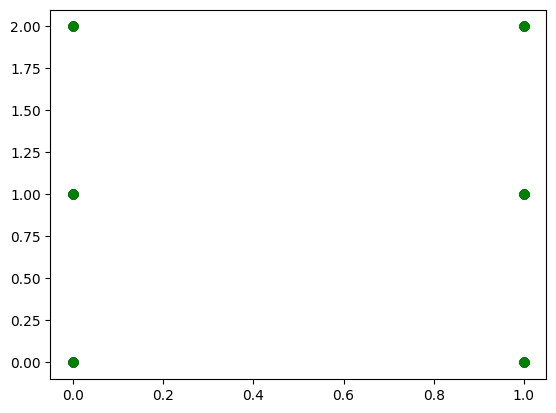

In [21]:
sex_by_vote = [[sex[i] for i in range(len(sex)) if vote[i] == vote_val] for vote_val in range(2)]
educ_by_vote = [[educ[i] for i in range(len(educ)) if vote[i] == vote_val] for vote_val in range(2)]

plt.plot(sex_by_vote[0], educ_by_vote[0], "ob")
plt.plot(sex_by_vote[1], educ_by_vote[1], "og")

##aceste criterii nu sunt de ajuns deoarece exista persoane cu acelasi sex / nivel de educatie care au votat cu ambii candidati
### putem vedea acest lucru din factul ca punctele albastre si verzi se suprapun

In [25]:
#pm.compute_log_likelihood(i_data,model=model1)
##am pus in comments pentru ca imi da eroare ca e deja calculat
waic1 = az.waic(i_data, scale="deviance")

#pm.compute_log_likelihood(i_data2,model=model2)
waic2 = az.waic(i_data2, scale="deviance")

print(waic1, waic2)

##al doilea model are waic mai mic -> este mai bun

Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 42110.71  4249.88
p_waic        20821.46        -

There has been a warning during the calculation. Please check the results. Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   485.39    25.10
p_waic            2.99        -


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


subiectul 2, punctul b

Pentru a decide care caracteristica separa cel mai bine datele ne putem uita la mediile / medianele clusterelor formate si sa alegem modelul unde acestea sunt cat mai departate unele de altele. Acest lucru ne indica ca clusterele create sunt distincte, ceea ce implica ca criteriul ales este descriptiv.